This notebook was developed by Tiffany Eulalio, modified by Minh Nguyen
# Labels

This notebook generates labels for the data upto 2020.

We will generate the following labels:
1. `admit_label`: level of care at time of admit
2. `24hr_label`: most recent level of care prior to 24 hrs after admit
3. `12hr_label`: most recent level of care prior to 12 hrs after admit
4. `acute_to_icu_label`: label switched from acute to ICU from admit to 24 hr time
4. `icu_to_acute_label`: label switched from ICU to acute from admit to 24 hr time


Labels 1 through 3 reflect the following:
- 1 = critical care
- 0 = not critical care 

Labels 4 through 5 reflect:
- 1 = switched care level
- 0 = did not switch care level

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os.path
from os import path
import math

In [ ]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

In [6]:
import os 
from google.cloud import bigquery
from google.cloud.bigquery import dbapi

##Use correct path based on whether you are, Nero or local
# use Ctrl + Insert to copy and Shift + Insert to paste

# for Nero:
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/minh084/.config/gcloud/application_default_credentials.json' 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/jupyter/.config/gcloud/application_default_credentials.json'

# for local computer:
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'C:\Users\User\AppData\Roaming\gcloud\application_default_credentials.json' 

##set correct Nero project
os.environ['GCLOUD_PROJECT'] = 'som-nero-phi-jonc101' 

##Setting up BQ API, m1:
client = bigquery.Client()

##using dbAPI connection, m2:
conn = dbapi.connect(client)

/opt/conda/lib/python3.7/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Download latest cohort data
The data was downloaded from the BQ from the `triageTD.cohort_enc_code_age` table. 

In [25]:
# load data from BQ, if not available already
q = "SELECT * FROM triageTD.1_2_cohort"
query_job = client.query(q).to_dataframe().to_csv(os.path.join(datadir,"1_2_cohort.csv"), index=False)

# Start Running from here if data is downloaded and saved already

In [3]:
forrepo = 1 # change this to 0 if you want to see hidden columns displayed

hidecols = []
if forrepo:
    hidecols=['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded'] # these are hidden columns

In [4]:
# folder with downloaded data locally
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
outdir = "../../OutputTD/1_cohort"

cohort = pd.read_csv("{}/1_2_cohort.csv".format(cohortdir))

# cohort.drop('Unnamed: 0', axis=1, inplace=True)

print(cohort.shape) # (45796, 16)
cohort.drop(hidecols, axis=1, errors='ignore').head()

(45796, 16)


,label,admit_time,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age
0,0,2019-05-05 01:07:00 UTC,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59
1,0,2019-09-10 11:45:00 UTC,3.0,2019-09-10 07:09:00 UTC,4.600000,Female,Other,Tongan,NaN,99.5,NaN,2020-03-31,51
2,0,2019-04-18 10:50:00 UTC,2.0,2019-04-18 09:46:00 UTC,1.066667,Female,Asian,Mandarin,NaN,64.0,NaN,2019-05-09,56
3,1,2020-01-17 05:55:00 UTC,2.0,2020-01-17 02:57:00 UTC,2.966667,Male,White,English,NaN,75.0,NaN,2020-02-20,70
4,0,2019-03-01 12:54:00 UTC,1.0,2019-03-01 11:20:00 UTC,1.566667,Female,Other,Spanish,NaN,75.8,NaN,2020-02-28,56


(The `admit_time` column contains the adjusted/earliest time between `admit_time_jittered` from the `ADT` table and the admission ordered time form the `order_proc` table. This is the time that we will use for the admission time.)

We are not going to use this admit time. Instead, we use the earliest admit time based on the `effective_time_jittered_utc` column in the `ADT` table. We'll grab the admit time from original init cohort0 for consistency, same as in `cohort_enc_code_age`

Looks like the admit time was already updated in this table. We can just use the original time.

# Pull the ADT table for this cohort

(We need to pull the `ADT` data for this new cohort. I already ran a SQL call directly on BQ to form the cohort and stored the table under `traige_TE.triage_cohort_adt_2019`

Here's the SQL code used:

`select shc.anon_id, shc.pat_enc_csn_id_coded, pat_class, pat_lv_of_care, event_type, pat_service, status_of_bed, accomodation
  from shc_core.adt shc
  right join conor_db.triage_cohort_draft_2019 c 
  on shc.anon_id = c.anon_id and shc.pat_enc_csn_id_coded = c.pat_enc_csn_id_coded`)
 
Pull the `ADT` data for this new cohort. Run a SQL call to form the cohort and stored the table under `triageTD.cohort_adt`

In [7]:
# query from BQ, if not available already
q = """
SELECT adt.anon_id, adt.pat_enc_csn_id_coded, adt.effective_time_jittered_utc, adt.seq_num_in_enc,
        adt.pat_class, adt.base_pat_class_c, adt.pat_lvl_of_care_c, adt.pat_lv_of_care, 
        adt.event_type, adt.pat_service
    
FROM shc_core.adt adt
RIGHT JOIN triageTD.1_2cohort c 
ON adt.anon_id = c.anon_id and adt.pat_enc_csn_id_coded = c.pat_enc_csn_id_coded
"""
query_job = client.query(q)
adt = query_job.to_dataframe() # not necessary?
# adt.to_csv(cohort_adt_file, index=False)
adt.to_csv(os.path.join(datadir, 'cohort_adt.csv'), index=None)

In [5]:
# connect to BQ - uncomment all of this if the data is not on computer
# cohort_adt_file = "../2019_data/triage_cohort_adt_2019.csv"

# %load_ext google.cloud.bigquery

In [6]:
# %%bigquery adt
# select *
# from traige_TE.triage_cohort_2019_adt

In [7]:
# # save the data
# adt.to_csv(cohort_adt_file, index=False)

# Load ADT table

Start here if the data has already been pulled from BQ.

In [5]:
# use this to describe the tables
def describe_df(df):
    print("df shape", df.shape)
    print("unique CSNs: ", df.pat_enc_csn_id_coded.nunique())
    print("unique patients: ", df.anon_id.nunique())

In [6]:
adt = pd.read_csv("{}/cohort_adt.csv".format(datadir))

describe_df(adt)

adt.drop(hidecols, axis=1, errors='ignore').head()

/home/eulalio/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


df shape (886988, 10)
unique CSNs:  45796
unique patients:  31513


,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service
0,2019-12-06 07:22:00+00:00,6,Inpatient,1.0,68.0,Newborn Nursery - VC Only,Patient Update,Emergency
1,2019-10-31 10:46:00+00:00,4,Inpatient,1.0,66.0,Neonatal ICU - VC Only,Patient Update,Emergency Medicine
2,2020-01-17 22:12:00+00:00,3,Inpatient,1.0,68.0,Newborn Nursery - VC Only,Patient Update,Emergency Medicine
3,2016-03-01 03:20:00+00:00,3,Inpatient,NaN,NaN,NaN,Transfer Out,Bone Marrow Transplant
4,2015-12-22 01:58:00+00:00,6,Inpatient,NaN,NaN,NaN,Transfer In,General Medicine (PAMF)


In [7]:
# join the adt to the cohort to make sure we have the correct cohort
joined_cohort_adt = cohort.merge(adt, on=['anon_id', 'pat_enc_csn_id_coded'],
                       how='left')

describe_df(joined_cohort_adt)

print(list(joined_cohort_adt.columns))

joined_cohort_adt.drop(hidecols, axis=1, errors='ignore').head()

df shape (886988, 24)
unique CSNs:  45796
unique patients:  31513
['anon_id', 'pat_enc_csn_id_coded', 'label', 'admit_time', 'inpatient_data_id_coded', 'ESI', 'hosp_admsn_time', 'ed_time_hr', 'gender', 'race', 'language', 'recent_height_cm', 'recent_weight_kg', 'insurance', 'recent_date', 'age', 'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class', 'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type', 'pat_service']


,label,admit_time,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service
0,0,2019-05-05 01:07:00 UTC,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59,2019-05-05 00:32:00+00:00,3,Emergency Services,NaN,NaN,NaN,Transfer In,Emergency
1,0,2019-05-05 01:07:00 UTC,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59,2019-05-05 00:32:00+00:00,2,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency
2,0,2019-05-05 01:07:00 UTC,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59,2019-05-05 00:06:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency
3,0,2019-05-05 01:07:00 UTC,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59,2019-05-15 03:11:00+00:00,21,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Discharge,Oncology
4,0,2019-05-05 01:07:00 UTC,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59,2019-05-05 01:07:00+00:00,4,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Patient Update,Oncology


In [8]:
print("cohort: ", cohort.shape, "adt: ", adt.shape, "joined_demo_adt: ", joined_cohort_adt.shape)

print("\nNumber of unique CSNs:")
print("cohort:", cohort.pat_enc_csn_id_coded.nunique(),
     "adt:", adt.pat_enc_csn_id_coded.nunique(),
     "joined:", joined_cohort_adt.pat_enc_csn_id_coded.nunique())

print("\nNumber of unique anon_ids:")
print("cohort:", cohort.anon_id.nunique(),
     "adt:", adt.anon_id.nunique(),
     "joined:", joined_cohort_adt.anon_id.nunique())

cohort:  (45796, 16) adt:  (886988, 10) joined_demo_adt:  (886988, 24)

Number of unique CSNs:
cohort: 45796 adt: 45796 joined: 45796

Number of unique anon_ids:
cohort: 31513 adt: 31513 joined: 31513


# Prepare table for making labels

We need to change the times into datetime format so we can work with them to create the labels. Also, create a column that tells us how long it's been since admit time for each event in the `ADT` table.

In [9]:
# change the admit time to datetime
joined_cohort_adt.admit_time = pd.to_datetime(joined_cohort_adt.admit_time)

# change the effective time to datetime
joined_cohort_adt['effective_time_jittered_utc'] = pd.to_datetime(joined_cohort_adt.effective_time_jittered_utc)

# change the event time to datetime
# joined_cohort_adt['event_time_jittered_utc'] = pd.to_datetime(joined_cohort_adt.event_time_jittered_utc)

In [10]:
joined_cohort_adt[['admit_time','effective_time_jittered_utc']].head()

,admit_time,effective_time_jittered_utc
0,2019-05-05 01:07:00+00:00,2019-05-05 00:32:00+00:00
1,2019-05-05 01:07:00+00:00,2019-05-05 00:32:00+00:00
2,2019-05-05 01:07:00+00:00,2019-05-05 00:06:00+00:00
3,2019-05-05 01:07:00+00:00,2019-05-15 03:11:00+00:00
4,2019-05-05 01:07:00+00:00,2019-05-05 01:07:00+00:00


In [11]:
# compute time since event - this step take a little while
joined_cohort_adt['effective_time_since_admit'] = joined_cohort_adt.apply(lambda x: x.effective_time_jittered_utc - x.admit_time, axis=1)
# joined_cohort_adt['event_time_since_admit'] = joined_cohort_adt.apply(lambda x: x.event_time_jittered_utc - x.admit_time, axis=1)

??? Check out the CSN from last time that was messed up. This CSN had two patients last time. Everything looks fine now. This CSN used to have two anon_id's in previous data.

In [23]:
time_used = "effective" # change this to look at the different times (either effective or event)
# time_used = "event"

key = "{}_time_since_admit".format(time_used)

# check out time since admit - some people have events prior to their admit_time label
print(joined_cohort_adt[key].describe(), "\n")

# look at all of the ADT events for these CSNs that occur prior to admission
prior_to_admit = joined_cohort_adt[joined_cohort_adt[key] < timedelta(hours=0)]

# number of ADT events that occur before admission
print("Number of ADT events that occur before admission: ", prior_to_admit.shape[0], "\n")

# this tells us where people were before admission
print("Pat class prior to admission: \n", prior_to_admit.pat_class.value_counts())

# how many csns have events prior to admit? 45,787
print(prior_to_admit.pat_enc_csn_id_coded.nunique())

prior_to_admit.drop(hidecols, axis=1, errors='ignore').head()
prior_to_admit.head()

count                        886988
mean      4 days 05:35:07.441656482
std      10 days 00:11:25.402281092
min               -8 days +01:34:00
25%                 0 days 01:09:00
50%                 0 days 22:03:00
75%                 4 days 04:21:00
max               232 days 03:20:00
Name: effective_time_since_admit, dtype: object 

Number of ADT events that occur before admission:  125964 

Pat class prior to admission: 
 Emergency Services    125962
Observation                2
Name: pat_class, dtype: int64
45787


,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,effective_time_since_admit
0,JC29f8b9c,131266787806,0,2019-05-05 01:07:00+00:00,36261582,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59,2019-05-05 00:32:00+00:00,3,Emergency Services,NaN,NaN,NaN,Transfer In,Emergency,-1 days +23:25:00
1,JC29f8b9c,131266787806,0,2019-05-05 01:07:00+00:00,36261582,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59,2019-05-05 00:32:00+00:00,2,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,-1 days +23:25:00
2,JC29f8b9c,131266787806,0,2019-05-05 01:07:00+00:00,36261582,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59,2019-05-05 00:06:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,-1 days +22:59:00
21,JC29fb54e,131274007955,0,2019-09-10 11:45:00+00:00,40209734,3.0,2019-09-10 07:09:00 UTC,4.600000,Female,Other,Tongan,NaN,99.5,NaN,2020-03-31,51,2019-09-10 07:09:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,-1 days +19:24:00
22,JC29fb54e,131274007955,0,2019-09-10 11:45:00+00:00,40209734,3.0,2019-09-10 07:09:00 UTC,4.600000,Female,Other,Tongan,NaN,99.5,NaN,2020-03-31,51,2019-09-10 07:12:00+00:00,2,Emergency Services,NaN,NaN,NaN,Patient Update,Emergency Medicine,-1 days +19:27:00


# Some patients have many CSNs in the cohort

Most patients only have one CSN in the `demo` table, but there are some with many CSNs. The max number of CSNs for one individual is 37. 

In [24]:
counts = joined_cohort_adt.groupby('anon_id')['pat_enc_csn_id_coded'].nunique().sort_values(ascending=False)

# distribution of CSNs per patient
print(counts.describe())

# number of patients with more than one CSN
print("\nPatients with multiple CSNs: ", sum(counts > 1))

counts.head(20)
# joined_cohort_adt[filtered_demo.anon_id == 'JCe8f38d'].sort_values('admit_time')

count    31513.000000
mean         1.453242
std          1.291380
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
Name: pat_enc_csn_id_coded, dtype: float64

Patients with multiple CSNs:  7318


anon_id
JCe8f38d     41
JC29fe299    38
JCdc9c9c     37
JC2a0d68b    36
JCdd32fa     35
JCcfe0cb     31
JCe228ac     28
JCdef5fd     26
JCd96890     24
JCe06f75     23
JCe93616     23
JCd28213     21
JCe04868     21
JCe6d7d9     21
JCcd77d8     20
JCd24ae9     20
JCe22af4     20
JCe66808     20
JCd8a0dd     20
JCd702f7     19
Name: pat_enc_csn_id_coded, dtype: int64

# (Look into event time and effective time differences)

# Make Label: Level of Care at Admit

We need to get the first admission event. 

# Patients missing lv of care 

There are some patients that are missing the `pat_lv_of_care` entry for the admit event. I looked through a handfull manually and it looks like these individuals tend to be missing the `pat_lv_of_care` for all of their ADT events. This means we can't assign them any labels and so should be removed from the dataset.

There are **1007** cases that have no admit lv of care. See the next two boxes below for more.

In [25]:
# try filtering for exact admit events
admit_events = joined_cohort_adt[joined_cohort_adt.admit_time == joined_cohort_adt.effective_time_jittered_utc] 
# admit_events = admit_events[admit_events.pat_class == "Inpatient"]

print("joined_cohort_adt")
describe_df(joined_cohort_adt)
print("\nadmit events")
describe_df(admit_events) # we don't lose any CSNs so that's good


# there are multiple admit events for some CSNs - check that the lv of care are the same
care_counts = admit_events.groupby(['pat_enc_csn_id_coded']).pat_lv_of_care.nunique()
print("\n",care_counts.describe())

# looks like some CSNs are missing an admit event label, 
# some have multiple level of care labels --> need to pull sequence numbers for events
missing_admits = care_counts[care_counts != 1].reset_index()

missing_admits.drop(hidecols, axis=1, errors='ignore')

joined_cohort_adt
df shape (886988, 25)
unique CSNs:  45796
unique patients:  31513

admit events
df shape (53789, 25)
unique CSNs:  45796
unique patients:  31513

 count    45796.000000
mean         0.977902
std          0.147892
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: pat_lv_of_care, dtype: float64


,pat_lv_of_care
0,0
1,0
2,0
3,0
4,0
...,...
1019,0
1020,0
1021,0
1022,0


In [31]:
cols = ['pat_class', 'pat_lv_of_care', 'admit_time', 'seq_num_in_enc', 
        'effective_time_jittered_utc', 'effective_time_since_admit',
       # 'event_time_since_admit', 'effective_minus_event_time', 'event_time_jittered_utc',
        'event_type', 'anon_id', 'pat_enc_csn_id_coded']

# check on these missing admit CSNs
i = 2
missing_csns = missing_admits[missing_admits.pat_lv_of_care == 0]


missing_csns = missing_csns.pat_enc_csn_id_coded.values
print("csns missing admit pat_lv_of_care: ", len(missing_csns))

missing_csn = missing_csns[i]
check = joined_cohort_adt[joined_cohort_adt.pat_enc_csn_id_coded == missing_csn]
check[cols].sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'effective_time_jittered_utc'])
# .drop(hidecols, axis=1, errors='ignore')

csns missing admit pat_lv_of_care:  1018


,pat_class,pat_lv_of_care,admit_time,seq_num_in_enc,effective_time_jittered_utc,effective_time_since_admit,event_type,anon_id,pat_enc_csn_id_coded
285637,Emergency Services,NaN,2015-01-07 01:02:00+00:00,1,2015-01-05 22:52:00+00:00,-2 days +21:50:00,Admission,JCde43c3,131063862033
285635,Emergency Services,NaN,2015-01-07 01:02:00+00:00,3,2015-01-06 03:07:00+00:00,-1 days +02:05:00,Transfer In,JCde43c3,131063862033
285645,Emergency Services,NaN,2015-01-07 01:02:00+00:00,2,2015-01-06 03:07:00+00:00,-1 days +02:05:00,Transfer Out,JCde43c3,131063862033
285646,Emergency Services,NaN,2015-01-07 01:02:00+00:00,4,2015-01-06 07:59:00+00:00,-1 days +06:57:00,Census,JCde43c3,131063862033
285642,Emergency Services,NaN,2015-01-07 01:02:00+00:00,6,2015-01-07 00:56:00+00:00,-1 days +23:54:00,Transfer In,JCde43c3,131063862033
285643,Emergency Services,NaN,2015-01-07 01:02:00+00:00,5,2015-01-07 00:56:00+00:00,-1 days +23:54:00,Transfer Out,JCde43c3,131063862033
285636,Inpatient,NaN,2015-01-07 01:02:00+00:00,8,2015-01-07 01:02:00+00:00,0 days 00:00:00,Transfer In,JCde43c3,131063862033
285638,Emergency Services,NaN,2015-01-07 01:02:00+00:00,7,2015-01-07 01:02:00+00:00,0 days 00:00:00,Transfer Out,JCde43c3,131063862033
285640,Inpatient,NaN,2015-01-07 01:02:00+00:00,9,2015-01-07 01:27:00+00:00,0 days 00:25:00,Transfer Out,JCde43c3,131063862033
285641,Inpatient,NaN,2015-01-07 01:02:00+00:00,10,2015-01-07 01:27:00+00:00,0 days 00:25:00,Transfer In,JCde43c3,131063862033


In [32]:
# find out when these missing admit individuals get their first label
len(missing_csns)

1018

In [87]:
# read in the final labels that we used
# final_labels = pd.read_csv("{}/cohort_labels.csv".format(datadir))

# final_labels.head().drop(hidecols, axis=1, errors='ignore')

,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label
0,0,2017-06-24 12:56:00+00:00,0.0,0,0.0,1,0,0,0,0
1,0,2015-02-18 20:54:00+00:00,0.0,0,0.0,1,0,0,0,0
2,0,2017-11-08 09:51:00+00:00,0.0,0,0.0,1,0,0,0,0
3,0,2019-04-17 16:25:00+00:00,0.0,0,0.0,1,0,0,0,0
4,0,2015-09-15 04:10:00+00:00,0.0,0,0.0,1,0,0,0,0


In [ ]:
# final_labels_sub = final_labels[final_labels.pat_enc_csn_id_coded.isin(cohort.pat_enc_csn_id_coded)]

# final_labels_sub.has_admit_label.value_counts()

In [ ]:
# extra_labels = final_labels_sub[(~final_labels_sub.pat_enc_csn_id_coded.isin(missing_csns)) &
#                                (final_labels_sub.has_admit_label == 0)]
# extra_labels.drop(hidecols, axis=1, errors='ignore')

In [ ]:
# check out these extra labels that are in the final labels but not found as missing admit labels here
# this might be an error - there are only 9 though so it's not a huge dealb
# i = 0
# extra_csns = extra_labels.pat_enc_csn_id_coded.values
# csn = extra_csns[i]

# print(len(extra_csns))

# joined_cohort_adt[joined_cohort_adt.pat_enc_csn_id_coded == csn].drop(hidecols, axis=1, errors='ignore')

In [33]:
# find patients with NaN only for lv of care
missing_adt = joined_cohort_adt[joined_cohort_adt.pat_enc_csn_id_coded.isin(missing_csns)]

not_all_nan = missing_adt[~missing_adt.pat_lv_of_care.isnull()]

not_all_nan_csns = not_all_nan.pat_enc_csn_id_coded.unique()

fully_missing_csns = [x for x in missing_csns if not x in not_all_nan_csns]

missing_csns_adt = cohort[cohort.pat_enc_csn_id_coded.isin(fully_missing_csns)]

print(len(fully_missing_csns))

# missing_csns_adt.to_csv("../2019_data/cohort_2019_missing_pat_lv_of_care.csv")

201


# Remove patients with no labels in any events

In [34]:
filtered_cohort_adt = joined_cohort_adt[~joined_cohort_adt.pat_enc_csn_id_coded.isin(fully_missing_csns)]

print("joined_cohort_adt")
describe_df(joined_cohort_adt)
print("\nfiltered_cohort_adt")
describe_df(filtered_cohort_adt) # removed 202 patients

filtered_cohort = cohort[~cohort.pat_enc_csn_id_coded.isin(fully_missing_csns)]
print("\n\njoined_cohort_adt")
describe_df(joined_cohort_adt)
print("\nfiltered_cohort")
describe_df(filtered_cohort) # removed 202 patients

joined_cohort_adt
df shape (886988, 25)
unique CSNs:  45796
unique patients:  31513

filtered_cohort_adt
df shape (884078, 25)
unique CSNs:  45595
unique patients:  31390


joined_cohort_adt
df shape (886988, 25)
unique CSNs:  45796
unique patients:  31513

filtered_cohort
df shape (45595, 16)
unique CSNs:  45595
unique patients:  31390


# Continue with patients that have admit events with lv of care 

In [35]:
# keep only patients with one lv of care label at admit time
counts = care_counts.reset_index()
keep_csns = counts[counts.pat_lv_of_care == 1].pat_enc_csn_id_coded.values

keep_admits = admit_events[admit_events.pat_enc_csn_id_coded.isin(keep_csns)]

print("filtered_cohort_adt")
describe_df(filtered_cohort_adt)
print("\nkeep admits")
describe_df(keep_admits) # there are multiple inpatient admit events, but they have the same label so it's okay

print("\nkeep admits + removed csns =", 
      keep_admits.pat_enc_csn_id_coded.nunique() + len(missing_csns)) # we're only missing the ones with no labels

print("\nmissing csns: ", len(missing_csns))

# keep only the first admit event for each csn
# all admit events have same label so it's okay to keep
unique_admits = keep_admits.groupby("pat_enc_csn_id_coded").first().reset_index()

admit_labels = unique_admits[['pat_enc_csn_id_coded', 'pat_lv_of_care']]
print(admit_labels.pat_lv_of_care.value_counts()) # these NeoNatal ICU and Newborn Nursery might be weird to keep ***

admit_labels['admit_label'] = (admit_labels.pat_lv_of_care == "Critical Care").astype(int)

print(admit_labels.admit_label.value_counts())

admit_labels.drop(hidecols, axis=1, errors='ignore')

filtered_cohort_adt
df shape (884078, 25)
unique CSNs:  45595
unique patients:  31390

keep admits
df shape (52289, 25)
unique CSNs:  44772
unique patients:  30914

keep admits + removed csns = 45790

missing csns:  1018
Acute Care (Assessment or intervention q4-8)                30496
Intermediate Care - With Cardiac Monitor                     6332
Critical Care                                                5119
IICU/Intermediate Care (Assessment or intervention q2-4)     2672
Intermediate Care - No Cardiac Monitor                        150
Newborn Nursery - VC Only                                       2
Neonatal ICU - VC Only                                          1
Name: pat_lv_of_care, dtype: int64
0    39653
1     5119
Name: admit_label, dtype: int64


<ipython-input-35-6156087b1168>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admit_labels['admit_label'] = (admit_labels.pat_lv_of_care == "Critical Care").astype(int)


,pat_lv_of_care,admit_label
0,Intermediate Care - With Cardiac Monitor,0
1,Acute Care (Assessment or intervention q4-8),0
2,Intermediate Care - With Cardiac Monitor,0
3,Acute Care (Assessment or intervention q4-8),0
4,Acute Care (Assessment or intervention q4-8),0
...,...,...
44767,Acute Care (Assessment or intervention q4-8),0
44768,Acute Care (Assessment or intervention q4-8),0
44769,Acute Care (Assessment or intervention q4-8),0
44770,Acute Care (Assessment or intervention q4-8),0


Checking out some of the weird admit labels (NeoNatal ICU and Newborn Nursery) - **keep or no?**

In [40]:
csn = admit_labels[admit_labels.pat_lv_of_care == 'Newborn Nursery - VC Only'].pat_enc_csn_id_coded.values[0]

In [39]:
check = filtered_cohort_adt[filtered_cohort_adt.pat_enc_csn_id_coded == csn]
check[cols].sort_values('effective_time_jittered_utc').drop(hidecols, axis=1, errors='ignore')

,pat_class,pat_lv_of_care,admit_time,seq_num_in_enc,effective_time_jittered_utc,effective_time_since_admit,event_type
540983,Emergency Services,NaN,2019-12-06 07:22:00+00:00,1,2019-12-06 00:58:00+00:00,-1 days +17:36:00,Admission
540984,Emergency Services,NaN,2019-12-06 07:22:00+00:00,3,2019-12-06 01:25:00+00:00,-1 days +18:03:00,Transfer In
540985,Emergency Services,NaN,2019-12-06 07:22:00+00:00,5,2019-12-06 01:25:00+00:00,-1 days +18:03:00,Transfer In
540986,Emergency Services,NaN,2019-12-06 07:22:00+00:00,4,2019-12-06 01:25:00+00:00,-1 days +18:03:00,Transfer Out
540987,Emergency Services,NaN,2019-12-06 07:22:00+00:00,2,2019-12-06 01:25:00+00:00,-1 days +18:03:00,Transfer Out
540982,Inpatient,Newborn Nursery - VC Only,2019-12-06 07:22:00+00:00,6,2019-12-06 07:22:00+00:00,0 days 00:00:00,Patient Update
540994,Inpatient,Acute Care (Assessment or intervention q4-8),2019-12-06 07:22:00+00:00,7,2019-12-06 07:29:00+00:00,0 days 00:07:00,Patient Update
540993,Inpatient,Acute Care (Assessment or intervention q4-8),2019-12-06 07:22:00+00:00,8,2019-12-06 07:59:00+00:00,0 days 00:37:00,Census
540988,Inpatient,Acute Care (Assessment or intervention q4-8),2019-12-06 07:22:00+00:00,9,2019-12-06 08:35:00+00:00,0 days 01:13:00,Transfer Out
540989,Inpatient,Acute Care (Assessment or intervention q4-8),2019-12-06 07:22:00+00:00,10,2019-12-06 08:35:00+00:00,0 days 01:13:00,Transfer In


In [42]:
filtered_cohort_labels = filtered_cohort.merge(admit_labels[['pat_enc_csn_id_coded', 'admit_label']], how='left')

# some are mising an admit label because they were NaN at admit time
sum(filtered_cohort_labels.admit_label.isnull())

filtered_cohort_labels.drop(hidecols, axis=1, errors='ignore')

,label,admit_time,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age,admit_label
0,0,2019-05-05 01:07:00 UTC,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59,0.0
1,0,2019-09-10 11:45:00 UTC,3.0,2019-09-10 07:09:00 UTC,4.600000,Female,Other,Tongan,NaN,99.50,NaN,2020-03-31,51,0.0
2,0,2019-04-18 10:50:00 UTC,2.0,2019-04-18 09:46:00 UTC,1.066667,Female,Asian,Mandarin,NaN,64.00,NaN,2019-05-09,56,0.0
3,1,2020-01-17 05:55:00 UTC,2.0,2020-01-17 02:57:00 UTC,2.966667,Male,White,English,NaN,75.00,NaN,2020-02-20,70,0.0
4,0,2019-03-01 12:54:00 UTC,1.0,2019-03-01 11:20:00 UTC,1.566667,Female,Other,Spanish,NaN,75.80,NaN,2020-02-28,56,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45590,0,2018-12-07 11:56:00 UTC,2.0,2018-12-07 11:14:00 UTC,0.700000,Female,White,English,170.18,76.20,MCAL HMO - CENTRAL CALIFORNIA ALLIANCE FOR HEALTH,2019-10-03,39,0.0
45591,0,2016-05-27 21:44:00 UTC,3.0,2016-05-27 19:29:00 UTC,2.250000,Female,Other,English,170.18,116.12,MCAL HMO - CENTRAL CALIFORNIA ALLIANCE FOR HEALTH,2019-08-09,62,0.0
45592,0,2018-05-30 04:17:00 UTC,3.0,2018-05-30 02:25:00 UTC,1.866667,Female,Other,Spanish,170.18,81.19,MCAL HMO - CENTRAL CALIFORNIA ALLIANCE FOR HEALTH,2020-03-31,32,0.0
45593,1,2018-12-23 14:41:00 UTC,3.0,2018-12-23 10:26:00 UTC,4.250000,Male,White,English,170.18,63.50,MCAL HMO - CENTRAL CALIFORNIA ALLIANCE FOR HEALTH,2019-01-01,52,1.0


# Most Recent Care Labels

Now we'll get the labels for the most recent event prior to X hours, for X=12 and 24.

In [43]:
X = 24

def get_adtX(X):
    # take only events that occur after admit but before the X hours mark
    adt_X = filtered_cohort_adt[(filtered_cohort_adt.effective_time_since_admit >= timedelta(hours=0))
                                 &
                                 (filtered_cohort_adt.effective_time_since_admit <= timedelta(hours=X))
                                &
                                (~filtered_cohort_adt.pat_lv_of_care.isnull())
                                ]

    # check out distribution of times
    print(adt_X.effective_time_since_admit.describe(), "\n")
    
    print("filtered_cohort_adt")
    describe_df(filtered_cohort_adt)
    print("\nadt_X")
    # check if we lost anyone - we're missing some
    describe_df(adt_X)


    print("\nmissing number of csns:")
    filtered_cohort_csns = filtered_cohort_adt.pat_enc_csn_id_coded.unique()
    adt_X_csns = adt_X.pat_enc_csn_id_coded.unique()
    print(len(filtered_cohort_csns) - len(adt_X_csns))
    
    # get these missing csns to manual check
    missing_csns = [x for x in filtered_cohort_csns if x not in adt_X_csns]
    
    return (adt_X, missing_csns)


adt_X, missing_csns = get_adtX(X=24)

count                       317129
mean     0 days 05:52:22.271000129
std      0 days 06:47:25.507735804
min                0 days 00:00:00
25%                0 days 01:01:00
50%                0 days 02:42:00
75%                0 days 08:54:00
max                1 days 00:00:00
Name: effective_time_since_admit, dtype: object 

filtered_cohort_adt
df shape (884078, 25)
unique CSNs:  45595
unique patients:  31390

adt_X
df shape (317129, 25)
unique CSNs:  45513
unique patients:  31346

missing number of csns:
82


# Missing 24 hour labels

There are 84 individuals missing 24 hr labels. I checked the first three and they seem to be those with NaN values for `pat_lv_of_care` for all events that occur within 24 hours.

In [44]:
i = 0
missing_csn = missing_csns[i]
check = filtered_cohort_adt[filtered_cohort_adt.pat_enc_csn_id_coded == missing_csn]
check[cols].sort_values('effective_time_jittered_utc').drop(hidecols, axis=1, errors='ignore')

,pat_class,pat_lv_of_care,admit_time,seq_num_in_enc,effective_time_jittered_utc,effective_time_since_admit,event_type
27841,Emergency Services,NaN,2015-12-27 02:29:00+00:00,1,2015-12-26 20:53:00+00:00,-1 days +18:24:00,Admission
27842,Inpatient,NaN,2015-12-27 02:29:00+00:00,2,2015-12-27 02:29:00+00:00,0 days 00:00:00,Patient Update
27844,Inpatient,NaN,2015-12-27 02:29:00+00:00,3,2015-12-27 07:59:00+00:00,0 days 05:30:00,Census
27845,Inpatient,NaN,2015-12-27 02:29:00+00:00,5,2015-12-27 21:20:00+00:00,0 days 18:51:00,Transfer In
27838,Inpatient,NaN,2015-12-27 02:29:00+00:00,4,2015-12-27 21:20:00+00:00,0 days 18:51:00,Transfer Out
27839,Inpatient,NaN,2015-12-27 02:29:00+00:00,7,2015-12-27 21:25:00+00:00,0 days 18:56:00,Transfer In
27840,Inpatient,NaN,2015-12-27 02:29:00+00:00,6,2015-12-27 21:25:00+00:00,0 days 18:56:00,Transfer Out
27836,Inpatient,NaN,2015-12-27 02:29:00+00:00,8,2015-12-28 01:36:00+00:00,0 days 23:07:00,Transfer Out
27843,Inpatient,NaN,2015-12-27 02:29:00+00:00,9,2015-12-28 01:36:00+00:00,0 days 23:07:00,Transfer In
27856,Inpatient,Acute Care (Assessment or intervention q4-8),2015-12-27 02:29:00+00:00,11,2015-12-28 04:52:00+00:00,1 days 02:23:00,Transfer In


In [46]:
def get_recent_events():
    # sort by the effective time of events
    adt_X.sort_values(by=['anon_id', 'pat_enc_csn_id_coded','effective_time_since_admit', 'seq_num_in_enc'], inplace=True)
    # 'seq_num_in_bed_min' - used to be sorted by this also, but we don't have this col anymore

    describe_df(adt_X)

    # group by CSN and get first event 
    recent_events = adt_X.groupby('pat_enc_csn_id_coded').last().reset_index()

    print(recent_events.effective_time_since_admit.describe())

    return recent_events

recent_events = get_recent_events()

df shape (317129, 25)
unique CSNs:  45513
unique patients:  31346
count                        45513
mean     0 days 13:38:20.407356140
std      0 days 07:11:50.936795742
min                0 days 00:00:00
25%                0 days 07:14:00
50%                0 days 13:49:00
75%                0 days 20:37:00
max                1 days 00:00:00
Name: effective_time_since_admit, dtype: object


<ipython-input-46-1b5d108c0279>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_X.sort_values(by=['anon_id', 'pat_enc_csn_id_coded','effective_time_since_admit', 'seq_num_in_enc'], inplace=True)


# Some patients' most recent event is very early

Minimum is 1 minute after admit. Check this guy out.

In [47]:
recent_events.sort_values(by=['effective_time_since_admit']).head().drop(hidecols, axis=1, errors='ignore')

,label,admit_time,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,effective_time_since_admit
45161,0,2020-03-31 07:00:00+00:00,2.0,2020-03-31 07:00:00 UTC,0.00,Male,Asian,Vietnamese,165.10,54.80,MEDICARE,2020-03-31,65,2020-03-31 07:00:00+00:00,6,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Census,Oncology,0 days
44905,0,2020-03-31 07:00:00+00:00,3.0,2020-03-31 07:00:00 UTC,0.00,Female,Other,English,160.00,98.40,None,2020-03-31,50,2020-03-31 07:00:00+00:00,8,Inpatient,1.0,9.0,IICU/Intermediate Care (Assessment or interven...,Census,Neurosurgery,0 days
45139,0,2020-03-31 07:00:00+00:00,3.0,2020-03-31 07:00:00 UTC,0.00,Male,White,English,187.96,84.82,BLUE SHIELD,2020-03-31,62,2020-03-31 07:00:00+00:00,5,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Census,Cardiology,0 days
45287,0,2020-03-31 07:00:00+00:00,3.0,2020-03-31 02:39:00 UTC,4.35,Male,White,English,NaN,78.90,COMMERCIAL OTHER,2020-03-31,51,2020-03-31 07:00:00+00:00,7,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Discharge,Trauma,0 days
18583,1,2017-05-25 08:12:00+00:00,3.0,2017-05-25 03:21:00 UTC,4.85,Female,White,English,160.02,78.20,MEDICARE,2019-01-01,87,2017-05-25 08:12:00+00:00,3,Inpatient,1.0,8.0,Critical Care,Patient Update,Trauma,0 days


In [48]:
# this checks out, so at least nothing wrong with code
check = filtered_cohort_adt[filtered_cohort_adt.pat_enc_csn_id_coded == 131087352675]
check[cols].sort_values('effective_time_since_admit').drop(hidecols, axis=1, errors='ignore')

,pat_class,pat_lv_of_care,admit_time,seq_num_in_enc,effective_time_jittered_utc,effective_time_since_admit,event_type
359600,Emergency Services,NaN,2015-04-30 06:58:00+00:00,1,2015-04-30 00:24:00+00:00,-1 days +17:26:00,Admission
359601,Emergency Services,NaN,2015-04-30 06:58:00+00:00,3,2015-04-30 06:49:00+00:00,-1 days +23:51:00,Transfer In
359603,Emergency Services,NaN,2015-04-30 06:58:00+00:00,2,2015-04-30 06:49:00+00:00,-1 days +23:51:00,Transfer Out
359602,Emergency Services,NaN,2015-04-30 06:58:00+00:00,4,2015-04-30 06:58:00+00:00,0 days 00:00:00,Transfer Out
359606,Inpatient,Critical Care,2015-04-30 06:58:00+00:00,5,2015-04-30 06:58:00+00:00,0 days 00:00:00,Transfer In
359607,Inpatient,Critical Care,2015-04-30 06:58:00+00:00,6,2015-04-30 06:59:00+00:00,0 days 00:01:00,Census
359609,Inpatient,Critical Care,2015-04-30 06:58:00+00:00,7,2015-05-01 06:59:00+00:00,1 days 00:01:00,Census
359605,Inpatient,Acute Care (Assessment or intervention q4-8),2015-04-30 06:58:00+00:00,9,2015-05-01 08:00:00+00:00,1 days 01:02:00,Transfer In
359608,Inpatient,Critical Care,2015-04-30 06:58:00+00:00,8,2015-05-01 08:00:00+00:00,1 days 01:02:00,Transfer Out
359604,Inpatient,Acute Care (Assessment or intervention q4-8),2015-04-30 06:58:00+00:00,10,2015-05-01 23:25:00+00:00,1 days 16:27:00,Discharge


In [49]:
# we have one row for each event now - each row is the last entry for each event prior to 24 hr mark
print(recent_events.pat_enc_csn_id_coded.nunique())
print(recent_events.shape)

describe_df(recent_events)

recent_events.effective_time_since_admit.describe()

45513
(45513, 25)
df shape (45513, 25)
unique CSNs:  45513
unique patients:  31346


count                        45513
mean     0 days 13:38:20.407356140
std      0 days 07:11:50.936795742
min                0 days 00:00:00
25%                0 days 07:14:00
50%                0 days 13:49:00
75%                0 days 20:37:00
max                1 days 00:00:00
Name: effective_time_since_admit, dtype: object

## Continue with labels again

In [50]:
# look at the level of care assignments across all individuals
print(recent_events.pat_lv_of_care.value_counts())

sum(recent_events.pat_lv_of_care.isnull()) # these are NaN lv of care prior to 24 hr

Acute Care (Assessment or intervention q4-8)                31176
Intermediate Care - With Cardiac Monitor                     6564
Critical Care                                                4466
IICU/Intermediate Care (Assessment or intervention q2-4)     3120
Intermediate Care - No Cardiac Monitor                        187
Name: pat_lv_of_care, dtype: int64


0

In [51]:
label_name = "label_{}hr_recent".format(X)
recent_events[label_name] = (recent_events.pat_lv_of_care == 'Critical Care').astype(int)
recent_events.head().drop(hidecols, axis=1, errors='ignore')

,label,admit_time,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,effective_time_since_admit,label_24hr_recent
0,0,2015-01-02 01:01:00+00:00,NaN,2015-01-01 17:10:00 UTC,7.850000,Female,White,English,152.40,55.60,HEALTHNET SENIOR ADVANTAGE,2020-01-10,83,2015-01-02 07:59:00+00:00,8,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Census,General Medicine (PAMF),0 days 06:58:00,0
1,0,2015-01-03 05:53:00+00:00,3.0,2015-01-03 01:56:00 UTC,3.950000,Female,White,English,154.50,49.20,BLUE SHIELD,2020-03-31,53,2015-01-04 00:29:00+00:00,11,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Patient Update,Orthopaedic Surgery,0 days 18:36:00,0
2,0,2015-01-01 08:24:00+00:00,2.0,2015-01-01 01:10:00 UTC,7.233333,Female,White,English,170.18,92.70,MEDICARE,2019-01-01,64,2015-01-02 07:59:00+00:00,11,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Census,Cardiology Transplant,0 days 23:35:00,0
3,0,2015-01-01 23:39:00+00:00,3.0,2015-01-01 17:07:00 UTC,6.533333,Male,White,English,185.42,101.90,AETNA,2019-01-01,25,2015-01-02 07:59:00+00:00,4,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Census,Psychiatry,0 days 08:20:00,0
4,0,2015-01-05 02:23:00+00:00,3.0,2015-01-04 18:13:00 UTC,8.166667,Female,Other,Spanish,152.40,40.37,COMMERCIAL OTHER,2019-01-01,34,2015-01-05 22:30:00+00:00,9,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Discharge,Neurology,0 days 20:07:00,0


In [52]:
# grab relevant columns
labels = recent_events[['pat_enc_csn_id_coded', label_name]]

# join to demo table
filtered_cohort_labels2 = filtered_cohort_labels.merge(labels, how='left', on='pat_enc_csn_id_coded')
filtered_cohort_labels2[label_name] = filtered_cohort_labels2[label_name]

filtered_cohort_labels2.head().drop(hidecols, axis=1, errors='ignore')

,label,admit_time,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age,admit_label,label_24hr_recent
0,0,2019-05-05 01:07:00 UTC,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59,0.0,0.0
1,0,2019-09-10 11:45:00 UTC,3.0,2019-09-10 07:09:00 UTC,4.600000,Female,Other,Tongan,NaN,99.5,NaN,2020-03-31,51,0.0,0.0
2,0,2019-04-18 10:50:00 UTC,2.0,2019-04-18 09:46:00 UTC,1.066667,Female,Asian,Mandarin,NaN,64.0,NaN,2019-05-09,56,0.0,0.0
3,1,2020-01-17 05:55:00 UTC,2.0,2020-01-17 02:57:00 UTC,2.966667,Male,White,English,NaN,75.0,NaN,2020-02-20,70,0.0,1.0
4,0,2019-03-01 12:54:00 UTC,1.0,2019-03-01 11:20:00 UTC,1.566667,Female,Other,Spanish,NaN,75.8,NaN,2020-02-28,56,0.0,0.0


# Make 12 hour most recent labels

In [53]:
X=12
adt_X, missing_csns = get_adtX(X=12)

count                       255696
mean     0 days 02:54:38.984418997
std      0 days 02:59:51.890118647
min                0 days 00:00:00
25%                0 days 00:44:00
50%                0 days 01:53:00
75%                0 days 04:13:00
max                0 days 12:00:00
Name: effective_time_since_admit, dtype: object 

filtered_cohort_adt
df shape (884078, 25)
unique CSNs:  45595
unique patients:  31390

adt_X
df shape (255696, 25)
unique CSNs:  45460
unique patients:  31319

missing number of csns:
135


# Missing 12 hr labels

There are 136 CSNs missing 12 hour labels. We can check out a couple of them. Looks legit. This should be a superset of the missing 24 hour label CSNs.

In [54]:
i = 0
missing_csn = missing_csns[i]
check = filtered_cohort_adt[filtered_cohort_adt.pat_enc_csn_id_coded == missing_csn]
check[cols].sort_values('effective_time_jittered_utc').drop(hidecols, axis=1, errors='ignore')

,pat_class,pat_lv_of_care,admit_time,seq_num_in_enc,effective_time_jittered_utc,effective_time_since_admit,event_type
13775,Emergency Services,NaN,2015-02-13 04:33:00+00:00,1,2015-02-12 21:33:00+00:00,-1 days +17:00:00,Admission
13771,Emergency Services,NaN,2015-02-13 04:33:00+00:00,3,2015-02-13 01:23:00+00:00,-1 days +20:50:00,Transfer In
13772,Emergency Services,NaN,2015-02-13 04:33:00+00:00,2,2015-02-13 01:23:00+00:00,-1 days +20:50:00,Transfer Out
13776,Emergency Services,NaN,2015-02-13 04:33:00+00:00,5,2015-02-13 04:28:00+00:00,-1 days +23:55:00,Transfer In
13777,Emergency Services,NaN,2015-02-13 04:33:00+00:00,4,2015-02-13 04:28:00+00:00,-1 days +23:55:00,Transfer Out
13770,Emergency Services,NaN,2015-02-13 04:33:00+00:00,6,2015-02-13 04:33:00+00:00,0 days 00:00:00,Transfer Out
13774,Inpatient,NaN,2015-02-13 04:33:00+00:00,7,2015-02-13 04:33:00+00:00,0 days 00:00:00,Transfer In
13773,Inpatient,NaN,2015-02-13 04:33:00+00:00,8,2015-02-13 07:59:00+00:00,0 days 03:26:00,Census
13769,Inpatient,NaN,2015-02-13 04:33:00+00:00,9,2015-02-14 03:56:00+00:00,0 days 23:23:00,Transfer Out
13778,Inpatient,Acute Care (Assessment or intervention q4-8),2015-02-13 04:33:00+00:00,10,2015-02-14 03:56:00+00:00,0 days 23:23:00,Transfer In


In [55]:
# get the last event within 12 hours for each CSN
recent_events = get_recent_events()

df shape (255696, 25)
unique CSNs:  45460
unique patients:  31319
count                        45460
mean     0 days 05:47:08.031236251
std      0 days 03:26:31.666848555
min                0 days 00:00:00
25%                0 days 02:46:00
50%                0 days 05:42:00
75%                0 days 08:43:00
max                0 days 12:00:00
Name: effective_time_since_admit, dtype: object


<ipython-input-46-1b5d108c0279>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_X.sort_values(by=['anon_id', 'pat_enc_csn_id_coded','effective_time_since_admit', 'seq_num_in_enc'], inplace=True)


In [56]:
# look at the level of care assignments across all individuals
print(recent_events.pat_lv_of_care.value_counts())

sum(recent_events.pat_lv_of_care.isnull()) # these are NaN lv of care prior to 24 hr

Acute Care (Assessment or intervention q4-8)                30072
Intermediate Care - With Cardiac Monitor                     6528
Critical Care                                                5375
IICU/Intermediate Care (Assessment or intervention q2-4)     3331
Intermediate Care - No Cardiac Monitor                        154
Name: pat_lv_of_care, dtype: int64


0

In [57]:
label_name = "label_{}hr_recent".format(X)
recent_events[label_name] = (recent_events.pat_lv_of_care == 'Critical Care').astype(int)

print(recent_events[label_name].value_counts())
recent_events.head().drop(hidecols, axis=1, errors='ignore')

0    40085
1     5375
Name: label_12hr_recent, dtype: int64


,label,admit_time,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,effective_time_since_admit,label_12hr_recent
0,0,2015-01-02 01:01:00+00:00,NaN,2015-01-01 17:10:00 UTC,7.850000,Female,White,English,152.40,55.60,HEALTHNET SENIOR ADVANTAGE,2020-01-10,83,2015-01-02 07:59:00+00:00,8,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Census,General Medicine (PAMF),0 days 06:58:00,0
1,0,2015-01-03 05:53:00+00:00,3.0,2015-01-03 01:56:00 UTC,3.950000,Female,White,English,154.50,49.20,BLUE SHIELD,2020-03-31,53,2015-01-03 07:59:00+00:00,10,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Census,Orthopaedic Surgery,0 days 02:06:00,0
2,0,2015-01-01 08:24:00+00:00,2.0,2015-01-01 01:10:00 UTC,7.233333,Female,White,English,170.18,92.70,MEDICARE,2019-01-01,64,2015-01-01 16:43:00+00:00,9,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Patient Update,Cardiology Transplant,0 days 08:19:00,0
3,0,2015-01-01 23:39:00+00:00,3.0,2015-01-01 17:07:00 UTC,6.533333,Male,White,English,185.42,101.90,AETNA,2019-01-01,25,2015-01-02 07:59:00+00:00,4,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Census,Psychiatry,0 days 08:20:00,0
4,0,2015-01-05 02:23:00+00:00,3.0,2015-01-04 18:13:00 UTC,8.166667,Female,Other,Spanish,152.40,40.37,COMMERCIAL OTHER,2019-01-01,34,2015-01-05 07:59:00+00:00,8,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Census,Neurology,0 days 05:36:00,0


In [58]:
# grab relevant columns
labels = recent_events[['pat_enc_csn_id_coded', label_name]]

# join to demo table
filtered_cohort_labels3 = filtered_cohort_labels2.merge(labels, how='left', on='pat_enc_csn_id_coded')
filtered_cohort_labels3[label_name] = filtered_cohort_labels3[label_name]

filtered_cohort_labels3.head().drop(hidecols, axis=1, errors='ignore')

,label,admit_time,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age,admit_label,label_24hr_recent,label_12hr_recent
0,0,2019-05-05 01:07:00 UTC,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59,0.0,0.0,0.0
1,0,2019-09-10 11:45:00 UTC,3.0,2019-09-10 07:09:00 UTC,4.600000,Female,Other,Tongan,NaN,99.5,NaN,2020-03-31,51,0.0,0.0,0.0
2,0,2019-04-18 10:50:00 UTC,2.0,2019-04-18 09:46:00 UTC,1.066667,Female,Asian,Mandarin,NaN,64.0,NaN,2019-05-09,56,0.0,0.0,0.0
3,1,2020-01-17 05:55:00 UTC,2.0,2020-01-17 02:57:00 UTC,2.966667,Male,White,English,NaN,75.0,NaN,2020-02-20,70,0.0,1.0,1.0
4,0,2019-03-01 12:54:00 UTC,1.0,2019-03-01 11:20:00 UTC,1.566667,Female,Other,Spanish,NaN,75.8,NaN,2020-02-28,56,0.0,0.0,0.0


In [59]:
filtered_cohort_labels3.admit_label = filtered_cohort_labels3.admit_label.astype("Int64")
filtered_cohort_labels3['label_24hr_recent'] = filtered_cohort_labels3['label_24hr_recent'].astype("Int64")
filtered_cohort_labels3['label_12hr_recent'] = filtered_cohort_labels3['label_12hr_recent'].astype("Int64")

filtered_cohort_labels3.drop(hidecols, axis=1, errors='ignore')

,label,admit_time,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age,admit_label,label_24hr_recent,label_12hr_recent
0,0,2019-05-05 01:07:00 UTC,2.0,2019-05-05 00:06:00 UTC,1.016667,Male,Unknown,NaN,NaN,NaN,NaN,2019-01-12,59,0,0,0
1,0,2019-09-10 11:45:00 UTC,3.0,2019-09-10 07:09:00 UTC,4.600000,Female,Other,Tongan,NaN,99.50,NaN,2020-03-31,51,0,0,0
2,0,2019-04-18 10:50:00 UTC,2.0,2019-04-18 09:46:00 UTC,1.066667,Female,Asian,Mandarin,NaN,64.00,NaN,2019-05-09,56,0,0,0
3,1,2020-01-17 05:55:00 UTC,2.0,2020-01-17 02:57:00 UTC,2.966667,Male,White,English,NaN,75.00,NaN,2020-02-20,70,0,1,1
4,0,2019-03-01 12:54:00 UTC,1.0,2019-03-01 11:20:00 UTC,1.566667,Female,Other,Spanish,NaN,75.80,NaN,2020-02-28,56,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45590,0,2018-12-07 11:56:00 UTC,2.0,2018-12-07 11:14:00 UTC,0.700000,Female,White,English,170.18,76.20,MCAL HMO - CENTRAL CALIFORNIA ALLIANCE FOR HEALTH,2019-10-03,39,0,0,0
45591,0,2016-05-27 21:44:00 UTC,3.0,2016-05-27 19:29:00 UTC,2.250000,Female,Other,English,170.18,116.12,MCAL HMO - CENTRAL CALIFORNIA ALLIANCE FOR HEALTH,2019-08-09,62,0,0,0
45592,0,2018-05-30 04:17:00 UTC,3.0,2018-05-30 02:25:00 UTC,1.866667,Female,Other,Spanish,170.18,81.19,MCAL HMO - CENTRAL CALIFORNIA ALLIANCE FOR HEALTH,2020-03-31,32,0,0,0
45593,1,2018-12-23 14:41:00 UTC,3.0,2018-12-23 10:26:00 UTC,4.250000,Male,White,English,170.18,63.50,MCAL HMO - CENTRAL CALIFORNIA ALLIANCE FOR HEALTH,2019-01-01,52,1,1,1


In [60]:
# check the missing label count for all three labels
print(sum(filtered_cohort_labels3.admit_label.isnull()))

print(sum(filtered_cohort_labels3['label_24hr_recent'].isnull()))

print(sum(filtered_cohort_labels3['label_12hr_recent'].isnull()))

823
82
135


In [61]:
print(filtered_cohort_labels3['admit_label'].value_counts(), "\n")
print(filtered_cohort_labels3['label_24hr_recent'].value_counts(), "\n")
print(filtered_cohort_labels3['label_12hr_recent'].value_counts(), "\n")

0    39653
1     5119
Name: admit_label, dtype: Int64 

0    41047
1     4466
Name: label_24hr_recent, dtype: Int64 

0    40085
1     5375
Name: label_12hr_recent, dtype: Int64 



In [49]:
# save these to file to upload to BQ
# filtered_cohort_labels3.to_csv("../2019_data/triage_cohort_final_with_labels.csv", index=False)

In [62]:
describe_df(filtered_cohort_labels3)

df shape (45595, 19)
unique CSNs:  45595
unique patients:  31390


# Create Switch Labels

We're creating labels that indicate whether a CSN switched from acute -> ICU or vice versa between admit time and 24 hours. For CSNs with both labels, this will be easy. 

However, some CSNs do not have admit labels, but they do have 24 hour labels. We will 
1. give these people a label based on their earliest level of care and their 24 hour label. 
2. We'll include a flag to indicate that these people didn't have admit labels. 
3. We'll also include the time of their earliest label.

In [51]:
# get flag to indicate whether individuals had an admit label
switch_labels = filtered_cohort_labels3
switch_labels['has_admit_label'] = (~switch_labels.admit_label.isnull()).astype(int)
print(switch_labels.has_admit_label.value_counts())

switch_labels.head()

# subset to those that do not have admit label
no_admit = switch_labels[switch_labels.has_admit_label == 0]
no_admit.head()
no_admit_csns = no_admit.pat_enc_csn_id_coded.values

print("new cohort:")
print(describe_df(filtered_cohort_labels3))
print("\nno admit")
print(describe_df(no_admit)) # 796 CSNs with no admit time

1    42475
0      816
Name: has_admit_label, dtype: int64
new cohort:
df shape (43291, 9)
unique CSNs:  43291
unique patients:  29936
None

no admit
df shape (816, 9)
unique CSNs:  816
unique patients:  803
None


# Missing all labels

There are some people who are missing labels for admit time, 12 hr, and 24 hr. We can't really do anything with these right now. We'll identify these individuals and remove them from the cohort.

We can also look at the distribution of their first labels.

1    84
Name: admit_label, dtype: int64
count     84.000000
mean      61.170238
std       60.744377
min       24.483333
25%       30.245833
50%       41.533333
75%       62.766667
max      363.033333
Name: effective_time_since_admit, dtype: float64


<AxesSubplot:>

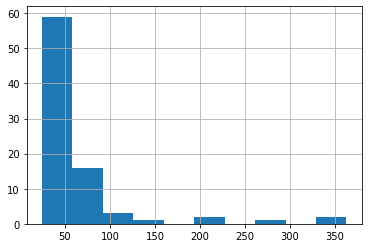

In [52]:
# find csns with no labels across the board
missing_labels = filtered_cohort_labels3[['admit_label', 
                        'label_12hr_recent', 'label_24hr_recent']].isnull().astype(int)
missing_labels['pat_enc_csn_id_coded'] = filtered_cohort_labels3['pat_enc_csn_id_coded']

no_admit = missing_labels[missing_labels.admit_label == 1] 
no_labels = no_admit[no_admit.label_24hr_recent == 1]

print(no_labels['admit_label'].value_counts()) # 82 people have no labels before 24 hrs

# manuall check some of them - looks good
# new_cohort[new_cohort.pat_enc_csn_id_coded == no_labels.pat_enc_csn_id_coded.values[50]]

no_labels_csns = no_labels.pat_enc_csn_id_coded.values # will probably remove these from cohort

# pull the adt for these CSNs with no admit times
no_labels_adt = filtered_cohort_adt[filtered_cohort_adt.pat_enc_csn_id_coded.isin(no_labels_csns)]

## these individuals must have a label somewhere, find out where

# sort out events with no lv of care
has_lv_of_care = no_labels_adt[~no_labels_adt.pat_lv_of_care.isnull()]
has_lv_of_care = has_lv_of_care[has_lv_of_care.effective_time_since_admit > timedelta(hours=0)]
has_lv_of_care.pat_enc_csn_id_coded.nunique() # we have at least one per csn 

# find first event for each csn
has_lv_of_care.sort_values(by=['pat_enc_csn_id_coded', 'event_time_jittered_utc'], inplace=True)
first_label = has_lv_of_care.groupby(['pat_enc_csn_id_coded']).first()

sec_since_admit = first_label.effective_time_since_admit.astype('timedelta64[s]')
hour_since_admit = sec_since_admit / 3600 # num of sec in an hour
print(hour_since_admit.describe())
hour_since_admit.hist()

# Continue without these individuals

732
732
count    732.000000
mean       4.287796
std       11.112857
min        0.016667
25%        0.362500
50%        1.858333
75%        4.266667
max      184.183333
Name: effective_time_since_admit, dtype: float64


<AxesSubplot:>

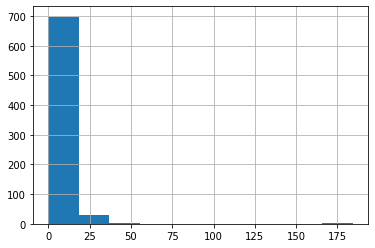

In [53]:
# keep the no_admit cohort but not the no_label cohort
has_some_label = filtered_cohort_labels3[~filtered_cohort_labels3.pat_enc_csn_id_coded.isin(no_labels_csns)] # 714 are left
switch_cohort = has_some_label[has_some_label.pat_enc_csn_id_coded.isin(no_admit_csns)]

## find the earliest level of care 
switch_cohort_csns = switch_cohort.pat_enc_csn_id_coded.values

# pull the adt for these CSNs with no admit times
switch_cohort_adt = filtered_cohort_adt[
    filtered_cohort_adt.pat_enc_csn_id_coded.isin(switch_cohort_csns)]

## these individuals must have a label somewhere, find out where

# sort out events with no lv of care
has_lv_of_care = switch_cohort_adt[~switch_cohort_adt.pat_lv_of_care.isnull()]
print(has_lv_of_care.pat_enc_csn_id_coded.nunique())
has_lv_of_care = has_lv_of_care[has_lv_of_care.effective_time_since_admit > timedelta(hours=0)]
print(has_lv_of_care.pat_enc_csn_id_coded.nunique()) # lost one patient here
has_lv_of_care.pat_enc_csn_id_coded.nunique() # we have at least one per csn 

# find first event for each csn
has_lv_of_care.sort_values(by=['pat_enc_csn_id_coded', 'event_time_jittered_utc',
                              'seq_num_in_enc', 'seq_num_in_bed_min'], inplace=True)
first_label = has_lv_of_care.groupby(['pat_enc_csn_id_coded']).first().reset_index()

sec_since_admit = first_label.effective_time_since_admit.astype('timedelta64[s]')
hour_since_admit = sec_since_admit / 3600 # num of sec in an hour
print(hour_since_admit.describe())
hour_since_admit.hist()

In [54]:
# we now have the first event for each CSN
first_label.pat_enc_csn_id_coded.nunique() # 713 - we have everyone, except that one that dropped off
first_label_short = first_label[['pat_enc_csn_id_coded', 'pat_lv_of_care', 'effective_time_since_admit']]

# check out lv of care here
print(first_label_short.pat_lv_of_care.value_counts())

# make sure no null values
print(sum(first_label_short.pat_lv_of_care.isnull())) # 0 = good

# create label
first_label_short['first_label'] = (first_label_short.pat_lv_of_care == 'Critical Care').astype(int)

print(first_label_short.first_label.value_counts()) # makes sense

# rename the time since admit column
first_label_short.rename({'effective_time_since_admit': 'first_label_time_since_admit'}, 
                         axis='columns', inplace=True)

first_label_short.drop(hidecols, axis=1, errors='ignore')

Acute Care (Assessment or intervention q4-8)                452
Intermediate Care - With Cardiac Monitor                    153
Critical Care                                                95
IICU/Intermediate Care (Assessment or intervention q2-4)     27
Intermediate Care - No Cardiac Monitor                        5
Name: pat_lv_of_care, dtype: int64
0
0    637
1     95
Name: first_label, dtype: int64


<ipython-input-54-0aa4c5853109>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_label_short['first_label'] = (first_label_short.pat_lv_of_care == 'Critical Care').astype(int)
/home/eulalio/.local/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,pat_lv_of_care,first_label_time_since_admit,first_label
0,Acute Care (Assessment or intervention q4-8),0 days 04:26:00,0
1,Acute Care (Assessment or intervention q4-8),0 days 02:11:00,0
2,Intermediate Care - With Cardiac Monitor,0 days 01:14:00,0
3,Critical Care,0 days 00:06:00,1
4,Acute Care (Assessment or intervention q4-8),0 days 04:23:00,0
...,...,...,...
727,Acute Care (Assessment or intervention q4-8),0 days 00:01:00,0
728,Acute Care (Assessment or intervention q4-8),0 days 00:01:00,0
729,IICU/Intermediate Care (Assessment or interven...,0 days 00:01:00,0
730,Acute Care (Assessment or intervention q4-8),0 days 00:01:00,0


# Checking into the first label time distribution

In [55]:
first_label_short['hours_since_admit'] = first_label_short.first_label_time_since_admit / pd.Timedelta('1 hour')

<ipython-input-55-f7208420a868>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_label_short['hours_since_admit'] = first_label_short.first_label_time_since_admit / pd.Timedelta('1 hour')


In [84]:
ordered_first_labels = first_label_short.sort_values('hours_since_admit', ascending=False)
ordered_first_labels.drop(hidecols, axis=1, errors='ignore')

,pat_lv_of_care,first_label_time_since_admit,first_label,hours_since_admit
514,Acute Care (Assessment or intervention q4-8),7 days 16:11:00,0,184.183333
96,Critical Care,7 days 13:14:00,1,181.233333
625,Acute Care (Assessment or intervention q4-8),2 days 22:06:00,0,70.100000
639,Acute Care (Assessment or intervention q4-8),2 days 05:26:00,0,53.433333
605,Critical Care,1 days 20:22:00,1,44.366667
...,...,...,...,...
645,Critical Care,0 days 00:01:00,1,0.016667
560,Acute Care (Assessment or intervention q4-8),0 days 00:01:00,0,0.016667
561,Acute Care (Assessment or intervention q4-8),0 days 00:01:00,0,0.016667
642,Acute Care (Assessment or intervention q4-8),0 days 00:01:00,0,0.016667


In [85]:
i=1
csn = ordered_first_labels.pat_enc_csn_id_coded.values[i]
joined_cohort_adt[joined_cohort_adt.pat_enc_csn_id_coded == csn][['pat_enc_csn_id_coded', 'admit_time',
                                                                 'pat_class', 'pat_lv_of_care',
                                                                 'effective_time_jittered_utc', 
                                                                 'event_time_jittered_utc',
                                                                 'effective_time_since_admit']].sort_values('effective_time_jittered_utc').drop(hidecols, axis=1, errors='ignore')

,admit_time,pat_class,pat_lv_of_care,effective_time_jittered_utc,event_time_jittered_utc,effective_time_since_admit
748978,2015-08-24 17:45:00+00:00,Emergency Services,NaN,2015-08-24 15:40:00+00:00,2015-08-24 15:40:00+00:00,-1 days +21:55:00
748979,2015-08-24 17:45:00+00:00,Emergency Services,NaN,2015-08-24 17:45:00+00:00,2015-08-24 18:07:00+00:00,0 days 00:00:00
748976,2015-08-24 17:45:00+00:00,Inpatient,NaN,2015-08-24 17:45:00+00:00,2015-08-24 18:07:00+00:00,0 days 00:00:00
748975,2015-08-24 17:45:00+00:00,Inpatient,NaN,2015-08-24 17:45:00+00:00,2015-08-24 18:43:00+00:00,0 days 00:00:00
748974,2015-08-24 17:45:00+00:00,Inpatient,NaN,2015-08-24 17:45:00+00:00,2015-08-24 18:43:00+00:00,0 days 00:00:00
748980,2015-08-24 17:45:00+00:00,Inpatient,Critical Care,2015-08-25 03:28:00+00:00,2016-03-21 21:49:00+00:00,0 days 09:43:00
748977,2015-08-24 17:45:00+00:00,Inpatient,NaN,2015-08-25 03:28:00+00:00,2016-03-21 21:49:00+00:00,0 days 09:43:00
748985,2015-08-24 17:45:00+00:00,Inpatient,Critical Care,2015-08-25 06:59:00+00:00,2016-03-21 21:49:00+00:00,0 days 13:14:00
748983,2015-08-24 17:45:00+00:00,Inpatient,Critical Care,2015-08-26 06:59:00+00:00,2016-03-21 21:49:00+00:00,1 days 13:14:00
748984,2015-08-24 17:45:00+00:00,Inpatient,Critical Care,2015-08-27 06:59:00+00:00,2016-03-21 21:49:00+00:00,2 days 13:14:00


In [86]:
i=1
csn = ordered_first_labels.pat_enc_csn_id_coded.values[i]
switch_cohort_adt[switch_cohort_adt.pat_enc_csn_id_coded == csn][['pat_enc_csn_id_coded', 'admit_time',
                                                                 'pat_class', 'pat_lv_of_care',
                                                                 'effective_time_jittered_utc', 
                                                                 'event_time_jittered_utc',
                                                                 'effective_time_since_admit']].sort_values('effective_time_jittered_utc').drop(hidecols, axis=1, errors='ignore')

,admit_time,pat_class,pat_lv_of_care,effective_time_jittered_utc,event_time_jittered_utc,effective_time_since_admit
748978,2015-08-24 17:45:00+00:00,Emergency Services,NaN,2015-08-24 15:40:00+00:00,2015-08-24 15:40:00+00:00,-1 days +21:55:00
748979,2015-08-24 17:45:00+00:00,Emergency Services,NaN,2015-08-24 17:45:00+00:00,2015-08-24 18:07:00+00:00,0 days 00:00:00
748976,2015-08-24 17:45:00+00:00,Inpatient,NaN,2015-08-24 17:45:00+00:00,2015-08-24 18:07:00+00:00,0 days 00:00:00
748975,2015-08-24 17:45:00+00:00,Inpatient,NaN,2015-08-24 17:45:00+00:00,2015-08-24 18:43:00+00:00,0 days 00:00:00
748974,2015-08-24 17:45:00+00:00,Inpatient,NaN,2015-08-24 17:45:00+00:00,2015-08-24 18:43:00+00:00,0 days 00:00:00
748980,2015-08-24 17:45:00+00:00,Inpatient,Critical Care,2015-08-25 03:28:00+00:00,2016-03-21 21:49:00+00:00,0 days 09:43:00
748977,2015-08-24 17:45:00+00:00,Inpatient,NaN,2015-08-25 03:28:00+00:00,2016-03-21 21:49:00+00:00,0 days 09:43:00
748985,2015-08-24 17:45:00+00:00,Inpatient,Critical Care,2015-08-25 06:59:00+00:00,2016-03-21 21:49:00+00:00,0 days 13:14:00
748983,2015-08-24 17:45:00+00:00,Inpatient,Critical Care,2015-08-26 06:59:00+00:00,2016-03-21 21:49:00+00:00,1 days 13:14:00
748984,2015-08-24 17:45:00+00:00,Inpatient,Critical Care,2015-08-27 06:59:00+00:00,2016-03-21 21:49:00+00:00,2 days 13:14:00


array([[<AxesSubplot:title={'center':'hours_since_admit'}>]], dtype=object)

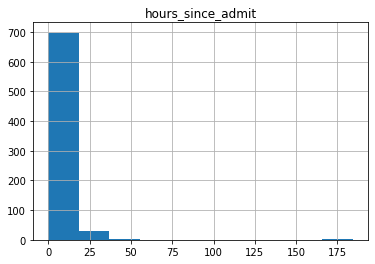

In [59]:
first_label_short.hist('hours_since_admit')

In [60]:
# join the first labels to the new cohort
new_cohort_labels = filtered_cohort_labels3.merge(first_label_short[['pat_enc_csn_id_coded', 'first_label', 'first_label_time_since_admit']],
                how='left')

In [61]:
new_cohort_labels_full = new_cohort_labels[~new_cohort_labels.pat_enc_csn_id_coded.isin(no_labels_csns)]

print("new cohort labels")
describe_df(new_cohort_labels)
print("\nnew cohort labels full")
describe_df(new_cohort_labels_full) # we lose those 82 csns that had no labels across the board

new cohort labels
df shape (43291, 11)
unique CSNs:  43291
unique patients:  29936

new cohort labels full
df shape (43207, 11)
unique CSNs:  43207
unique patients:  29891


# Looking at patient trajectories

Some people do not go straight from Emergency Services to Inpatient. They go to other places like Observation in between. I don't remember if this was what we wanted to do. 

In [62]:
df_temp = filtered_cohort_adt.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 
                                            'event_time_jittered_utc', 'seq_num_in_enc', 'seq_num_in_bed_min'])

# keep only cases where pat_lv_of_care changed from row above or csn changed
# logic: (row.csn == last.csn) --> (row.care != last.care) ::: p --> q
# equivalent: (!(row.csn == last.csn) OR (row.care != last.care)) ::: !p OR q
df_temp['csn_pat_class'] = df_temp.pat_enc_csn_id_coded.astype(str) + df_temp.pat_class

df_temp['match'] = ~(df_temp.csn_pat_class ==  df_temp.csn_pat_class.shift())
df_temp

df_change = df_temp[~(df_temp.csn_pat_class ==  df_temp.csn_pat_class.shift())]
                                      

# want to see trajectories for each patient on the adt table
grouped = df_change.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'effective_time_jittered_utc'])[['pat_enc_csn_id_coded', 'pat_class']]
pat_traj = grouped.groupby('pat_enc_csn_id_coded').pat_class.apply(lambda x: ' -> '.join(x)).reset_index()

# join to the adt table
pat_traj['trajectory'] = pat_traj.pat_class
new_adt = filtered_cohort_adt.merge(pat_traj, how='left', on='pat_enc_csn_id_coded')

trajectories = new_adt.trajectory.unique()

new_adt.drop(hidecols, axis=1, errors='ignore').head()

,label_max24,admit_time,pat_class_x,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,seq_num_in_enc,seq_num_in_bed_min,effective_time_since_admit,event_time_since_admit,effective_minus_event_time,pat_class_y,trajectory
0,0,2017-06-24 12:56:00+00:00,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2017-06-24 05:13:00+00:00,2017-06-24 05:13:00+00:00,1,1.0,-1 days +16:17:00,-1 days +16:17:00,0 days 00:00:00,Emergency Services -> Inpatient,Emergency Services -> Inpatient
1,0,2017-06-24 12:56:00+00:00,Emergency Services,NaN,Census,Emergency,NaN,Ward,2017-06-24 06:59:00+00:00,2017-06-24 06:59:00+00:00,2,1.0,-1 days +18:03:00,-1 days +18:03:00,0 days 00:00:00,Emergency Services -> Inpatient,Emergency Services -> Inpatient
2,0,2017-06-24 12:56:00+00:00,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer Out,Orthopaedic Surgery,NaN,Ward,2017-06-25 01:17:00+00:00,2017-06-25 01:17:00+00:00,12,1.0,0 days 12:21:00,0 days 12:21:00,0 days 00:00:00,Emergency Services -> Inpatient,Emergency Services -> Inpatient
3,0,2017-06-24 12:56:00+00:00,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer Out,Orthopaedic Surgery,NaN,Ward,2017-06-24 20:28:00+00:00,2017-06-24 20:37:00+00:00,10,1.0,0 days 07:32:00,0 days 07:41:00,-1 days +23:51:00,Emergency Services -> Inpatient,Emergency Services -> Inpatient
4,0,2017-06-24 12:56:00+00:00,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer Out,Orthopaedic Surgery,NaN,Ward,2017-06-24 17:53:00+00:00,2017-06-24 17:53:00+00:00,8,1.0,0 days 04:57:00,0 days 04:57:00,0 days 00:00:00,Emergency Services -> Inpatient,Emergency Services -> Inpatient


In [63]:
counts = pat_traj.groupby('trajectory').pat_enc_csn_id_coded.count().reset_index()
print(counts.sort_values('pat_enc_csn_id_coded', ascending=False).head(50))

                                            trajectory  pat_enc_csn_id_coded
41                     Emergency Services -> Inpatient                 41441
75      Emergency Services -> Inpatient -> Observation                   716
21   Emergency Services -> Emergency Services -> In...                   181
77   Emergency Services -> Inpatient -> Observation...                   157
65   Emergency Services -> Inpatient -> OP Surgery/...                   122
43   Emergency Services -> Inpatient -> Bedded Outp...                    91
58   Emergency Services -> Inpatient -> Inpatient -...                    85
94      Emergency Services -> Observation -> Inpatient                    74
67   Emergency Services -> Inpatient -> OP Surgery/...                    50
10   Emergency Services -> Emergency Services -> Be...                    48
49   Emergency Services -> Inpatient -> Emergency S...                    34
101  Emergency Services -> Observation -> Observati...                    28

In [64]:
for i in range(len(trajectories)):
    print(i, " : ", trajectories[i])

0  :  Emergency Services -> Inpatient
1  :  Emergency Services -> Emergency Services -> OP Surgery/Procedure -> OP Surgery/Procedure -> Inpatient
2  :  Emergency Services -> Inpatient -> Observation
3  :  Emergency Services -> Emergency Services -> Inpatient -> Inpatient
4  :  Emergency Services -> Emergency Services -> Bedded Outpatient (corrections only) -> Bedded Outpatient (corrections only) -> Observation -> Observation -> Inpatient
5  :  Emergency Services -> Inpatient -> Observation -> Inpatient
6  :  Emergency Services -> Inpatient -> Bedded Outpatient (corrections only) -> Observation
7  :  Emergency Services -> Inpatient -> Observation -> OP Surgery/Procedure -> Inpatient
8  :  Emergency Services -> Emergency Services -> Observation -> Observation -> Inpatient -> Inpatient
9  :  Emergency Services -> Inpatient -> OP Surgery/Procedure
10  :  Emergency Services -> Emergency Services -> Bedded Outpatient (corrections only) -> Observation -> Inpatient
11  :  Emergency Services ->

In [65]:
i = 12
traj = trajectories[i]
print(traj)
traj_csns = new_adt[new_adt.trajectory == traj].pat_enc_csn_id_coded.values

k = 0
df_temp[df_temp.pat_enc_csn_id_coded == traj_csns[k]].sort_values('effective_time_jittered_utc').drop(hidecols, axis=1, errors='ignore')

Emergency Services -> Observation -> OP Surgery/Procedure -> OP Surgery/Procedure -> OP Surgery/Procedure -> Inpatient


,label_max24,admit_time,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,seq_num_in_enc,seq_num_in_bed_min,effective_time_since_admit,event_time_since_admit,effective_minus_event_time,csn_pat_class,match
11474,0,2016-04-16 22:25:00+00:00,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2016-04-14 22:02:00+00:00,2016-04-14 22:02:00+00:00,1,1.0,-3 days +23:37:00,-3 days +23:37:00,0 days 00:00:00,131181039759Emergency Services,True
11487,0,2016-04-16 22:25:00+00:00,Observation,Acute Care (Assessment or intervention q4-8),Patient Update,Hepatology,NaN,Semi-Private,2016-04-15 00:02:00+00:00,2016-04-23 04:21:00+00:00,2,1.0,-2 days +01:37:00,6 days 05:56:00,-9 days +19:41:00,131181039759Observation,True
11482,0,2016-04-16 22:25:00+00:00,Observation,Acute Care (Assessment or intervention q4-8),Transfer In,Hepatology,NaN,Ward,2016-04-15 01:28:00+00:00,2016-04-23 04:21:00+00:00,4,1.0,-2 days +03:03:00,6 days 05:56:00,-9 days +21:07:00,131181039759Observation,False
11481,0,2016-04-16 22:25:00+00:00,Observation,Acute Care (Assessment or intervention q4-8),Transfer Out,Hepatology,NaN,Semi-Private,2016-04-15 01:28:00+00:00,2016-04-23 04:21:00+00:00,3,1.0,-2 days +03:03:00,6 days 05:56:00,-9 days +21:07:00,131181039759Observation,False
11484,0,2016-04-16 22:25:00+00:00,Observation,Acute Care (Assessment or intervention q4-8),Census,Hepatology,NaN,Ward,2016-04-15 06:59:00+00:00,2016-04-23 04:21:00+00:00,5,1.0,-2 days +08:34:00,6 days 05:56:00,-8 days +02:38:00,131181039759Observation,False
11488,0,2016-04-16 22:25:00+00:00,Observation,Acute Care (Assessment or intervention q4-8),Transfer Out,Hepatology,NaN,Ward,2016-04-15 23:28:00+00:00,2016-04-23 04:21:00+00:00,6,1.0,-1 days +01:03:00,6 days 05:56:00,-8 days +19:07:00,131181039759Observation,False
11483,0,2016-04-16 22:25:00+00:00,Observation,Acute Care (Assessment or intervention q4-8),Transfer In,Hepatology,NaN,Ward,2016-04-15 23:28:00+00:00,2016-04-23 04:21:00+00:00,7,1.0,-1 days +01:03:00,6 days 05:56:00,-8 days +19:07:00,131181039759Observation,False
11490,0,2016-04-16 22:25:00+00:00,Observation,Acute Care (Assessment or intervention q4-8),Census,Hepatology,NaN,Ward,2016-04-16 06:59:00+00:00,2016-04-23 04:21:00+00:00,8,1.0,-1 days +08:34:00,6 days 05:56:00,-7 days +02:38:00,131181039759Observation,False
11489,0,2016-04-16 22:25:00+00:00,Observation,Acute Care (Assessment or intervention q4-8),Transfer Out,Hepatology,NaN,Ward,2016-04-16 20:13:00+00:00,2016-04-23 04:21:00+00:00,9,1.0,-1 days +21:48:00,6 days 05:56:00,-7 days +15:52:00,131181039759Observation,False
11485,0,2016-04-16 22:25:00+00:00,Observation,Acute Care (Assessment or intervention q4-8),Transfer In,Hepatology,NaN,Ward,2016-04-16 20:13:00+00:00,2016-04-23 04:21:00+00:00,10,1.0,-1 days +21:48:00,6 days 05:56:00,-7 days +15:52:00,131181039759Observation,False


# Back to the switch labels

In [66]:
print(new_cohort_labels_full.has_admit_label.value_counts())
new_cohort_labels_full.drop(hidecols, axis=1, errors='ignore')

1    42475
0      732
Name: has_admit_label, dtype: int64


,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit
0,0,2017-06-24 12:56:00+00:00,0,0,0,1,NaN,NaT
1,0,2015-02-18 20:54:00+00:00,0,0,0,1,NaN,NaT
2,0,2017-11-08 09:51:00+00:00,0,0,0,1,NaN,NaT
3,0,2019-04-17 16:25:00+00:00,0,0,0,1,NaN,NaT
4,0,2015-09-15 04:10:00+00:00,0,0,0,1,NaN,NaT
...,...,...,...,...,...,...,...,...
43286,1,2019-06-11 15:20:00+00:00,1,1,1,1,NaN,NaT
43287,1,2019-07-31 07:10:00+00:00,1,1,1,1,NaN,NaT
43288,1,2019-06-03 07:27:00+00:00,1,1,1,1,NaN,NaT
43289,1,2019-04-05 21:27:00+00:00,1,1,1,1,NaN,NaT


In [67]:
# move values from events that have admit labels to first label
def first_label(row):
    if isinstance(row['admit_label'], int):
        return row.admit_label
    else:
        return row.first_label

def first_label_time(row):
    if isinstance(row['admit_label'], int):
        return 0
    else:
        return row.first_label_time_since_admit

new_cohort_labels_full['first_label_full'] = new_cohort_labels_full.apply(lambda row: 
                                                                          first_label(row),
                                                                         axis=1)
new_cohort_labels_full['first_label_time_since_admit_full'] = new_cohort_labels_full.apply(lambda row: 
                                                                          first_label_time(row),
                                                                         axis=1)

print(new_cohort_labels_full.first_label_full.value_counts())
print(new_cohort_labels_full.first_label.value_counts())
print(sum(new_cohort_labels_full.first_label_full.isnull()))

new_cohort_labels_full.drop(hidecols, axis=1, errors='ignore')

<ipython-input-67-01026ac22f71>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cohort_labels_full['first_label_full'] = new_cohort_labels_full.apply(lambda row:


0.0    38326
1.0     4881
Name: first_label_full, dtype: int64
0.0    637
1.0     95
Name: first_label, dtype: int64
0


<ipython-input-67-01026ac22f71>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cohort_labels_full['first_label_time_since_admit_full'] = new_cohort_labels_full.apply(lambda row:


,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,first_label_full,first_label_time_since_admit_full
0,0,2017-06-24 12:56:00+00:00,0,0,0,1,NaN,NaT,0.0,0
1,0,2015-02-18 20:54:00+00:00,0,0,0,1,NaN,NaT,0.0,0
2,0,2017-11-08 09:51:00+00:00,0,0,0,1,NaN,NaT,0.0,0
3,0,2019-04-17 16:25:00+00:00,0,0,0,1,NaN,NaT,0.0,0
4,0,2015-09-15 04:10:00+00:00,0,0,0,1,NaN,NaT,0.0,0
...,...,...,...,...,...,...,...,...,...,...
43286,1,2019-06-11 15:20:00+00:00,1,1,1,1,NaN,NaT,1.0,0
43287,1,2019-07-31 07:10:00+00:00,1,1,1,1,NaN,NaT,1.0,0
43288,1,2019-06-03 07:27:00+00:00,1,1,1,1,NaN,NaT,1.0,0
43289,1,2019-04-05 21:27:00+00:00,1,1,1,1,NaN,NaT,1.0,0


In [68]:
# sanity check
check = new_cohort_labels_full
print(sum(check.first_label_full.isnull()))
print(sum(check.first_label_time_since_admit_full.isnull()))


check = new_cohort_labels_full[new_cohort_labels_full.admit_label.isnull()]

print(sum(check.first_label_full.isnull()))
print(sum(check.first_label_time_since_admit_full.isnull()))

check.drop(hidecols, axis=1, errors='ignore')

0
0
0
0


,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,first_label_full,first_label_time_since_admit_full
15,0,2015-05-22 16:10:00+00:00,<NA>,0,0,0,0.0,0 days 06:22:00,0.0,0 days 06:22:00
39,0,2018-09-25 14:15:00+00:00,<NA>,0,0,0,0.0,2 days 05:26:00,0.0,2 days 05:26:00
156,0,2015-08-08 01:52:00+00:00,<NA>,0,0,0,0.0,0 days 04:17:00,0.0,0 days 04:17:00
164,0,2016-02-07 00:02:00+00:00,<NA>,0,0,0,0.0,0 days 00:50:00,0.0,0 days 00:50:00
234,0,2015-12-31 03:29:00+00:00,<NA>,0,0,0,0.0,0 days 03:07:00,0.0,0 days 03:07:00
...,...,...,...,...,...,...,...,...,...,...
43112,1,2019-08-15 05:26:00+00:00,<NA>,1,1,0,1.0,0 days 00:06:00,1.0,0 days 00:06:00
43128,1,2019-05-30 06:41:00+00:00,<NA>,1,1,0,1.0,0 days 00:01:00,1.0,0 days 00:01:00
43205,1,2019-07-04 23:13:00+00:00,<NA>,0,0,0,0.0,0 days 00:01:00,0.0,0 days 00:01:00
43262,1,2019-01-08 22:52:00+00:00,<NA>,1,1,0,1.0,0 days 00:08:00,1.0,0 days 00:08:00


In [69]:
check = new_cohort_labels_full[~new_cohort_labels_full.admit_label.isnull()]

print(sum(check.first_label_full.isnull()))
print(sum(check.first_label_time_since_admit_full.isnull()))

check.drop(hidecols, axis=1, errors='ignore')

0
0


,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,first_label_full,first_label_time_since_admit_full
0,0,2017-06-24 12:56:00+00:00,0,0,0,1,NaN,NaT,0.0,0
1,0,2015-02-18 20:54:00+00:00,0,0,0,1,NaN,NaT,0.0,0
2,0,2017-11-08 09:51:00+00:00,0,0,0,1,NaN,NaT,0.0,0
3,0,2019-04-17 16:25:00+00:00,0,0,0,1,NaN,NaT,0.0,0
4,0,2015-09-15 04:10:00+00:00,0,0,0,1,NaN,NaT,0.0,0
...,...,...,...,...,...,...,...,...,...,...
43286,1,2019-06-11 15:20:00+00:00,1,1,1,1,NaN,NaT,1.0,0
43287,1,2019-07-31 07:10:00+00:00,1,1,1,1,NaN,NaT,1.0,0
43288,1,2019-06-03 07:27:00+00:00,1,1,1,1,NaN,NaT,1.0,0
43289,1,2019-04-05 21:27:00+00:00,1,1,1,1,NaN,NaT,1.0,0


# Create switch labels now

In [70]:
# new_cohort_labels_full.first_label_full = new_cohort_labels_full.first_label_full

# acute to critical
new_cohort_labels_full['acute_to_critical_label'] = (
    (new_cohort_labels_full.first_label_full == 0) &
    (new_cohort_labels_full.label_24hr_recent == 1)).astype(int)

new_cohort_labels_full.acute_to_critical_label.value_counts()

<ipython-input-70-fbc7b972f003>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cohort_labels_full['acute_to_critical_label'] = (


0    42320
1      887
Name: acute_to_critical_label, dtype: int64

In [71]:
# critical to acute
new_cohort_labels_full['critical_to_acute_label'] = (
    (new_cohort_labels_full.first_label_full == 1) &
    (new_cohort_labels_full.label_24hr_recent == 0)).astype(int)

new_cohort_labels_full.critical_to_acute_label.value_counts()

<ipython-input-71-3c51cb94f367>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cohort_labels_full['critical_to_acute_label'] = (


0    41636
1     1571
Name: critical_to_acute_label, dtype: int64

In [72]:
new_cohort_labels_full.drop(hidecols, axis=1, errors='ignore')

,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,first_label_full,first_label_time_since_admit_full,acute_to_critical_label,critical_to_acute_label
0,0,2017-06-24 12:56:00+00:00,0,0,0,1,NaN,NaT,0.0,0,0,0
1,0,2015-02-18 20:54:00+00:00,0,0,0,1,NaN,NaT,0.0,0,0,0
2,0,2017-11-08 09:51:00+00:00,0,0,0,1,NaN,NaT,0.0,0,0,0
3,0,2019-04-17 16:25:00+00:00,0,0,0,1,NaN,NaT,0.0,0,0,0
4,0,2015-09-15 04:10:00+00:00,0,0,0,1,NaN,NaT,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43286,1,2019-06-11 15:20:00+00:00,1,1,1,1,NaN,NaT,1.0,0,0,0
43287,1,2019-07-31 07:10:00+00:00,1,1,1,1,NaN,NaT,1.0,0,0,0
43288,1,2019-06-03 07:27:00+00:00,1,1,1,1,NaN,NaT,1.0,0,0,0
43289,1,2019-04-05 21:27:00+00:00,1,1,1,1,NaN,NaT,1.0,0,0,0


In [73]:
final_labels = new_cohort_labels_full.copy()

# drop unwanted columns
final_labels.drop(['first_label', 'first_label_time_since_admit'], axis=1, errors='ignore',
                 inplace=True)

# rename columns
final_labels.rename({'first_label_full': 'first_label',
                    'first_label_time_since_admit_full': 'first_label_time_since_admit'},
                   inplace=True, axis=1)

# final_labels['first_label'] = final_labels.first_label.astype(int)

final_labels.drop(hidecols, axis=1, errors='ignore')

,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label
0,0,2017-06-24 12:56:00+00:00,0,0,0,1,0.0,0,0,0
1,0,2015-02-18 20:54:00+00:00,0,0,0,1,0.0,0,0,0
2,0,2017-11-08 09:51:00+00:00,0,0,0,1,0.0,0,0,0
3,0,2019-04-17 16:25:00+00:00,0,0,0,1,0.0,0,0,0
4,0,2015-09-15 04:10:00+00:00,0,0,0,1,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
43286,1,2019-06-11 15:20:00+00:00,1,1,1,1,1.0,0,0,0
43287,1,2019-07-31 07:10:00+00:00,1,1,1,1,1.0,0,0,0
43288,1,2019-06-03 07:27:00+00:00,1,1,1,1,1.0,0,0,0
43289,1,2019-04-05 21:27:00+00:00,1,1,1,1,1.0,0,0,0


In [74]:
# save to file
final_labels.to_csv("{}/triage_cohort_2019_all_labels.csv".format(datadir), index=False)

In [75]:
final_labels = pd.read_csv("{}/triage_cohort_2019_all_labels.csv".format(datadir))

In [76]:
describe_df(final_labels)

df shape (43207, 13)
unique CSNs:  43207
unique patients:  29891


In [77]:
for colname in final_labels.columns:
    print(final_labels[colname].value_counts())
    print(sum(final_labels[colname].isnull()))

JCe8f38d     37
JC29fe299    36
JC2a0d68b    35
JCdd32fa     34
JCdc9c9c     32
             ..
JCd072c1      1
JCe00d1f      1
JCe67c20      1
JCdd139e      1
JCd806da      1
Name: anon_id, Length: 29891, dtype: int64
0
131092346895    1
131276096061    1
131262157351    1
131267395763    1
131080552997    1
               ..
131257910941    1
131268653608    1
131261174370    1
131269834044    1
131268050928    1
Name: pat_enc_csn_id_coded, Length: 43207, dtype: int64
0
25690112    1
33704636    1
25875119    1
35332785    1
29506226    1
           ..
30764186    1
22541684    1
17431925    1
26010998    1
33886206    1
Name: inpatient_data_id_coded, Length: 43207, dtype: int64
0
0    37233
1     5974
Name: label_max24, dtype: int64
0
2019-10-05 01:25:00+00:00    3
2018-06-26 01:39:00+00:00    3
2015-07-29 05:24:00+00:00    3
2018-09-09 00:41:00+00:00    3
2017-09-15 23:40:00+00:00    2
                            ..
2017-05-10 20:24:00+00:00    1
2017-04-03 11:46:00+00:00    1
2017

# Update format of table columns

There is a column that is a double, so we will update to keep everything consistent.

In [78]:
final_labels = pd.read_csv("{}/triage_cohort_2019_all_labels.csv".format(datadir))
final_labels.head().drop(hidecols, axis=1, errors='ignore')

,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label
0,0,2017-06-24 12:56:00+00:00,0.0,0,0.0,1,0.0,0,0,0
1,0,2015-02-18 20:54:00+00:00,0.0,0,0.0,1,0.0,0,0,0
2,0,2017-11-08 09:51:00+00:00,0.0,0,0.0,1,0.0,0,0,0
3,0,2019-04-17 16:25:00+00:00,0.0,0,0.0,1,0.0,0,0,0
4,0,2015-09-15 04:10:00+00:00,0.0,0,0.0,1,0.0,0,0,0


In [79]:
# find the types of each column
final_labels.dtypes

anon_id                          object
pat_enc_csn_id_coded              int64
inpatient_data_id_coded           int64
label_max24                       int64
admit_time                       object
admit_label                     float64
label_24hr_recent                 int64
label_12hr_recent               float64
has_admit_label                   int64
first_label                     float64
first_label_time_since_admit     object
acute_to_critical_label           int64
critical_to_acute_label           int64
dtype: object

In [80]:
# change any of the float columns to int64
float_cols = ['admit_label', 'label_12hr_recent', 'first_label']

for col in float_cols:
    final_labels[col] = final_labels[col].astype('Int64')

final_labels.dtypes

anon_id                         object
pat_enc_csn_id_coded             int64
inpatient_data_id_coded          int64
label_max24                      int64
admit_time                      object
admit_label                      Int64
label_24hr_recent                int64
label_12hr_recent                Int64
has_admit_label                  int64
first_label                      Int64
first_label_time_since_admit    object
acute_to_critical_label          int64
critical_to_acute_label          int64
dtype: object

In [81]:
final_labels.head().drop(hidecols, axis=1, errors='ignore')

,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label
0,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,0,0,0
1,0,2015-02-18 20:54:00+00:00,0,0,0,1,0,0,0,0
2,0,2017-11-08 09:51:00+00:00,0,0,0,1,0,0,0,0
3,0,2019-04-17 16:25:00+00:00,0,0,0,1,0,0,0,0
4,0,2015-09-15 04:10:00+00:00,0,0,0,1,0,0,0,0


In [82]:
# final cohort size is 42,475
print(sum(final_labels.admit_label.isnull()))
print(sum(~final_labels.admit_label.isnull()))

final_labels.shape

732
42475


(43207, 13)

In [83]:
# save to file
final_labels.to_csv("{}/triage_to_keep_cohort_with_labels_updated.csv".format(datadir), index=False)